# Input Data

## Per-response features

Extraction (stage 2) produces one `.npz` per role containing:
- `mean_features`: `[n_responses, D]` — mean-pooled SAE activations per response
- `max_features`: `[n_responses, D]` — max-pooled SAE activations per response

where `D = 65,536` (SAE width) and responses are generated from 5 instruction variants x 240 questions.

## Aggregated role matrix

Aggregation (stage 3) collapses responses per role:

`F[r, j] = mean_q X_r[q, j]`

producing `per_role.npz` with shape `[R, D]` where `R` is the number of roles (50 in the current dataset).

This matrix `F` is the starting point for feature selection, though for question-centering {role}.npz files are used too.

# Feature Selection

Select features using role-agnostic quality + stability filtering, ranked by cross-role variance.

**Pipeline:** not dead → has variance → stable across resamples → rank by `stability × sd`, take top K.

In [1]:
from pathlib import Path

AGGREGATED_DIR = Path("../outputs/aggregated/general/gemma-3-27b-it_layer_40_width_65k_l0_medium") # [n_roles, D]
FEATURES_DIR = Path("../outputs/features/general/gemma-3-27b-it_layer_40_width_65k_l0_medium") # [n_responses, D] per role
OUTPUT_DIR = Path("../outputs/figures")

STRATEGY = "mean" # or "max"
TOP_K = 2000

# Optional: subtract response-index-shared signal across roles before role aggregation.
# Use this when all roles were generated on the same question/prompt rows.
USE_QUESTION_CENTERING = True


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, leaves_list
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.auto import tqdm
from umap import UMAP

/home/abu/projects/mech-interp-projects/interpret-personas/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Aggregated Data

In [3]:
data = np.load(AGGREGATED_DIR / STRATEGY / "per_role.npz", allow_pickle=True)
features_raw = data["features"].astype(np.float32, copy=False) # [R, D] R = num roles, D = SAE dim
role_names = data["role_names"]
n_roles, sae_dim = features_raw.shape
print(f"{n_roles} roles, {sae_dim:,} SAE features")

features = features_raw.copy()
question_baseline = None

if USE_QUESTION_CENTERING:
    if STRATEGY != "mean":
        raise ValueError("USE_QUESTION_CENTERING currently supports STRATEGY='mean' only.")

    print("Building response-index baseline across roles...")
    sum_resp = None
    n_responses = None

    for role in tqdm(role_names, desc="Accumulating baseline"):
        with np.load(FEATURES_DIR / f"{role}.npz") as npz:
            resp = npz[f"{STRATEGY}_features"].astype(np.float32, copy=False)

        if sum_resp is None:
            n_responses = resp.shape[0]
            sum_resp = np.zeros_like(resp, dtype=np.float32)
        elif resp.shape[0] != n_responses:
            raise ValueError(
                f"Row-count mismatch for role {role}: got {resp.shape[0]}, expected {n_responses}"
            )

        sum_resp += resp

    question_baseline = sum_resp / n_roles
    del sum_resp

    centered = np.zeros((n_roles, sae_dim), dtype=np.float32)
    for r, role in enumerate(tqdm(role_names, desc="Centering role means")):
        with np.load(FEATURES_DIR / f"{role}.npz") as npz:
            resp = npz[f"{STRATEGY}_features"].astype(np.float32, copy=False)
        centered[r] = (resp - question_baseline).mean(axis=0)

    features = centered
    print("Question-centering active: using mean(role_response - cross-role row baseline).")


50 roles, 65,536 SAE features
Building response-index baseline across roles...


Centering role means: 100%|██████████| 50/50 [00:35<00:00,  1.42it/s]

Question-centering active: using mean(role_response - cross-role row baseline).


### Question centered

All roles answer the same 240 questions in the same order. This creates shared signal: topic vocabulary, answer scaffolding, generic assistant behavior. Question centering removes this shared signal. For each response row `q` and feature `j`, compute the cross-role baseline:

`B[q, j] = (1/R) * sum_r X_r[q, j]` where X_r is [n_responses, D] for each role and R is num_roles

Then center each role's responses:

`Xc_r[q, j] = X_r[q, j] - B[q, j]`

The centered role mean is:

`Fc[r, j] = mean_q Xc_r[q, j]`

This is equivalent to a simpler operation at the role level:

`R = F - mean_r F`

The resulting `R` contains signed residuals: positive means the role activates this feature above the cross-role baseline, negative means below.

# Selection Process

The goal is to:

1. Keep features that vary across roles so that we get persona specific features
2. Keep features whole role pattern is stable across sampled responses so that we minimize prompt variation

The intuition is that features like punctuation, grammar, etc. mostly gets filtered out because they show less variation across roles.

## Step 1: Log Transform + Drop Dead / Low-Variance Features

### Non-centered

Log1p prevents activation spikes from skewing the distribution, so one huge role activation does not dominate everything.

### Centered

Centered features are used directly without converting them to log scale.

---

Resulting filter keeps features that are active (mean > 0) and variation is above median variation. Each mean and std is calculated within each feature.

In [4]:
if USE_QUESTION_CENTERING:
    # Signed role deviations after centering (can be negative).
    R = features
else:
    # Positive role activations for the default path.
    R = np.log1p(features)

mu = R.mean(axis=0)
sd = R.std(axis=0)

if USE_QUESTION_CENTERING:
    alive = np.linalg.norm(R, axis=0) > 0
else:
    alive = mu > 0

sd_threshold = np.median(sd[alive]) if alive.any() else 0.0
pass_basic = alive & (sd >= sd_threshold)

print(f"Alive features: {alive.sum():,}")
print(f"SD threshold (median of alive): {sd_threshold:.4f}")
print(f"After basic filter: {pass_basic.sum():,}")
if USE_QUESTION_CENTERING:
    print("Step-1 matrix: centered role deviations (not log1p activations).")


Alive features: 64,330
SD threshold (median of alive): 0.0807
After basic filter: 32,165
Step-1 matrix: centered role deviations (not log1p activations).


## Step 2: Compute Split-Half Stability

For each role, shuffle its response rows and split into two halves. Compute one mean feature vector per half, giving matrices `A[R, D]` and `B[R, D]`.

For each feature `j`:

`stability[j] = cosine(A[:, j], B[:, j])`

A heuristic to obtain features that are stable within the role.

Under question centering, the split-half means are also centered by subtracting the baseline mean for the same split rows. This tests reproducibility of the role *residual* direction, not the raw activation direction.

Computing split-half means: 100%|██████████| 50/50 [00:35<00:00,  1.39it/s]


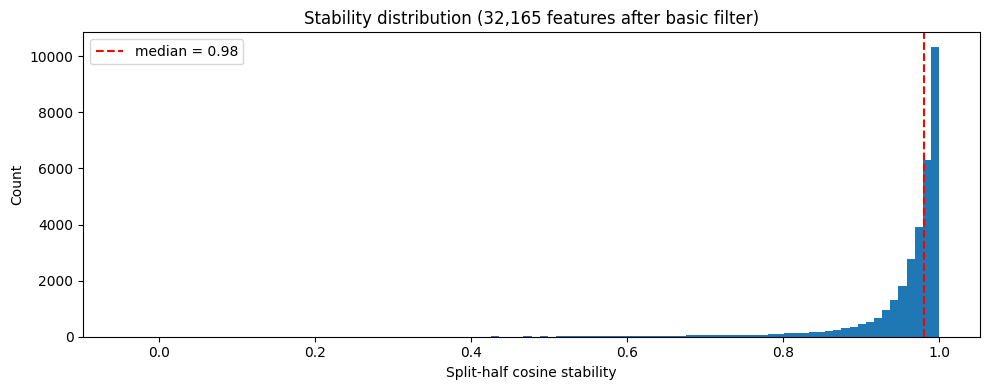

In [5]:
A = np.zeros((n_roles, sae_dim), dtype=np.float32)
B = np.zeros((n_roles, sae_dim), dtype=np.float32)

rng = np.random.RandomState(42)
for r, role in enumerate(tqdm(role_names, desc="Computing split-half means")):
    with np.load(FEATURES_DIR / f"{role}.npz") as npz:
        resp = npz[f"{STRATEGY}_features"].astype(np.float32, copy=False)

    if USE_QUESTION_CENTERING:
        if question_baseline is None:
            raise RuntimeError("question_baseline is None while USE_QUESTION_CENTERING=True")
        if resp.shape != question_baseline.shape:
            raise ValueError(
                f"Shape mismatch for role {role}: resp={resp.shape}, baseline={question_baseline.shape}"
            )
        resp = resp - question_baseline

    idx = rng.permutation(resp.shape[0])
    mid = resp.shape[0] // 2
    A[r] = resp[idx[:mid]].mean(axis=0)
    B[r] = resp[idx[mid:]].mean(axis=0)

num = (A * B).sum(axis=0)
den = np.linalg.norm(A, axis=0) * np.linalg.norm(B, axis=0)
stability = np.divide(num, den, out=np.zeros(sae_dim, dtype=np.float32), where=den > 0)

del A, B

fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(stability[pass_basic], bins=100, edgecolor="none")
ax.set_xlabel("Split-half cosine stability")
ax.set_ylabel("Count")
ax.set_title(f"Stability distribution ({pass_basic.sum():,} features after basic filter)")
median_stab = np.median(stability[pass_basic])
ax.axvline(median_stab, color="red", linestyle="--", label=f"median = {median_stab:.2f}")
ax.legend()
plt.tight_layout()
plt.show()


## Step 3: Ranking

A threshold-free way to select features. stability * sd helps ranking these cases lower:

- high variance but unstable
- stable but flat (not informative, common in all roles)
- either weakness

In [6]:
score = stability * sd
score[~pass_basic] = -1

ranking = np.argsort(score)[::-1]
selected = ranking[:TOP_K]

print(f"Selected {len(selected):,} features")
print(f"Score range: [{score[selected[-1]]:.4f}, {score[selected[0]]:.4f}]")
print(f"Stability range: [{stability[selected].min():.3f}, {stability[selected].max():.3f}]")
print(f"SD range: [{sd[selected].min():.4f}, {sd[selected].max():.4f}]")

Selected 2,000 features
Score range: [5.3375, 333.6665]
Stability range: [0.954, 1.000]
SD range: [5.3430, 333.6974]


## Feature Summary

In [7]:
preferred_role_idx = R[:, selected].argmax(axis=0)

def role_profile(feat_idx, role_values, role_names, top_n=3):
    vals = role_values[:, feat_idx]
    total = vals.sum()
    if total <= 0:
        return "no positive role mass"
    order = np.argsort(vals)[::-1][:top_n]
    return " | ".join(f"{role_names[i]}:{vals[i] / total:.0%}" for i in order)


role_values_for_profile = np.clip(R, 0, None) if USE_QUESTION_CENTERING else R

feat_df = pd.DataFrame({
    "feature_idx": selected,
    "preferred_role": role_names[preferred_role_idx],
    "score": score[selected],
    "stability": stability[selected],
    "sd": sd[selected],
    "mu": mu[selected],
    "role_profile": [role_profile(fi, role_values_for_profile, role_names) for fi in selected],
})

if USE_QUESTION_CENTERING:
    preferred_role_idx_raw = np.log1p(features_raw)[:, selected].argmax(axis=0)
    feat_df["preferred_role_raw"] = role_names[preferred_role_idx_raw]

print("Features per preferred role:")
print(feat_df["preferred_role"].value_counts().to_string())


Features per preferred role:
preferred_role
zealot            108
caveman           108
adolescent         87
gossip             73
fool               69
addict             63
swarm              59
historian          58
economist          53
aberration         49
hedonist           49
absurdist          48
immigrant          47
avatar             46
anarchist          46
psychologist       46
amateur            43
alien              43
musician           42
ghost              42
pirate             41
sommelier          40
exile              39
lawyer             38
loner              37
mathematician      36
bohemian           34
altruist           33
analyst            33
engineer           32
marketer           31
biologist          31
assistant          31
anthropologist     31
demon              29
teacher            29
student            28
actor              26
spy                26
guru               25
activist           25
accountant         22
doctor             22
collaborat

## Visualizations

### Role-Role Cosine Similarity

The role-role similarity matrix is cosine similarity computed on `R[:, selected]` — each role represented by its selected-feature profile.

In [13]:
from scipy.spatial.distance import squareform
import plotly.graph_objects as go

role_vectors = R[:, selected]  # [50, top_k] - each row is a role feature profile
role_sim = cosine_similarity(role_vectors)

distance = 1 - role_sim
np.fill_diagonal(distance, 0.0)
link = linkage(squareform(distance, checks=False), method="average")
order = leaves_list(link)

sim_ord = role_sim[np.ix_(order, order)]
names_ord = role_names[order]

fig = go.Figure(
    data=go.Heatmap(
        z=sim_ord,
        x=names_ord,
        y=names_ord,
        colorscale="RdBu",
        reversescale=True,
        zmin=-1,
        zmax=1,
        zmid=0,
        colorbar={"title": "Cosine Similarity"},
        hovertemplate="x=%{x}<br>y=%{y}<br>cos=%{z:.3f}<extra></extra>",
    )
)
fig.update_layout(
    title="Role-Role Similarity",
    width=1000,
    height=900,
)
fig.update_xaxes(tickangle=45)
fig.update_yaxes(autorange="reversed")
heatmap_html = OUTPUT_DIR / "role_similarity_heatmap_interactive.html"
heatmap_png = OUTPUT_DIR / "role_similarity_heatmap.png"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

fig.write_html(heatmap_html, include_plotlyjs="cdn")
print(f"Saved interactive heatmap to {heatmap_html}")

try:
    fig.write_image(heatmap_png, width=1400, height=1200, scale=2)
    print(f"Saved static heatmap to {heatmap_png}")
except Exception as e:
    print(f"Could not save PNG (install kaleido): {e}")

fig.show()


Saved interactive heatmap to ../outputs/figures/role_similarity_heatmap_interactive.html
Saved static heatmap to ../outputs/figures/role_similarity_heatmap.png


### UMAP of Features

Each feature is a point in role-space. Distance = "these features prefer similar personas."

Each row of `feat_vectors` is one selected feature represented by its activation profile across roles. This is the embedding used for neighbors, projections, and quality metrics.

**UMAP** is fit on `feat_vectors` with cosine metric. It (mostly) preserves local neighborhood structure — features with similar role profiles cluster together. UMAP is the default map layout.

**PCA** provides a deterministic linear alternative. It finds the axes of maximum variance in feature role-profiles.

/home/abu/projects/mech-interp-projects/interpret-personas/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


/tmp/ipykernel_6888/514356179.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(unique_roles))


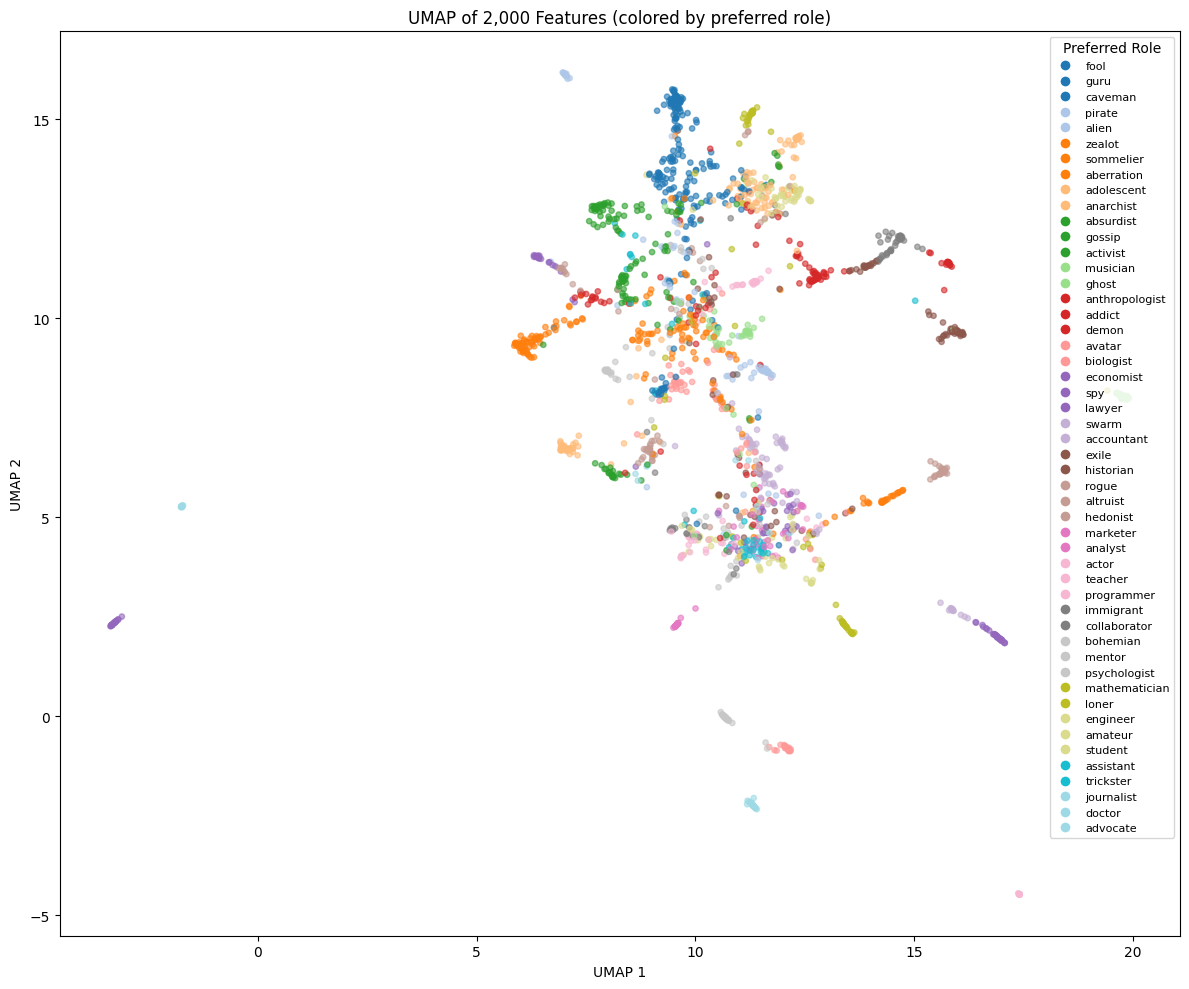

In [9]:
feat_vectors = R[:, selected].T  # [top_k, n_roles] — each row is a feature's role profile

feat_umap = UMAP(
    n_components=2, metric="cosine",
    n_neighbors=15, min_dist=0.1, random_state=24,
).fit_transform(feat_vectors)

unique_roles = feat_df["preferred_role"].unique()
cmap = plt.cm.get_cmap("tab20", len(unique_roles))
role_to_idx = {r: i for i, r in enumerate(unique_roles)}
colors = [role_to_idx[r] for r in feat_df["preferred_role"]]

fig, ax = plt.subplots(figsize=(12, 10))
ax.scatter(
    feat_umap[:, 0], feat_umap[:, 1],
    c=colors, cmap=cmap, vmin=0, vmax=len(unique_roles) - 1,
    s=15, alpha=0.6,
)
handles = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=cmap(i), markersize=8, label=r)
    for i, r in enumerate(unique_roles)
]
ax.legend(handles=handles, title="Preferred Role", loc="upper right", fontsize=8)
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_title(f"UMAP of {TOP_K:,} Features (colored by preferred role)")
plt.tight_layout()
plt.show()

### PCA of Roles and the Assistant Axis

Each role is a point in feature-space. PCA finds the linear axes along which roles differ most. Each PC axis is a weighted combination of SAE features (`pca.components_`), so inspecting the top-weighted features on an axis can reveal what it captures (e.g. "assistant-like vs. absurd"). A role's score on PC1 is how far it sits along the dominant axis of variation.

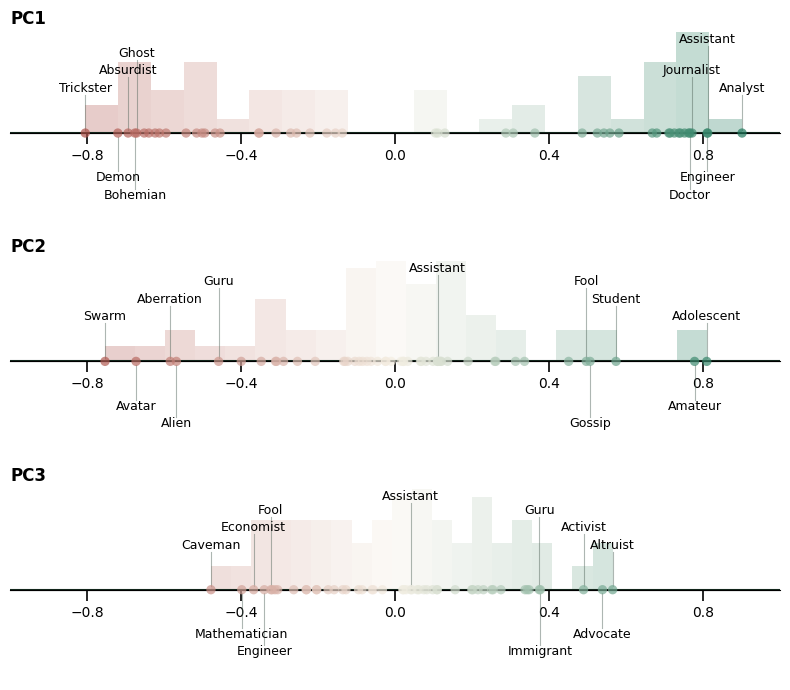

Variance explained by first 3 PCs:
  PC1: 32.1%
  PC2: 12.1%
  PC3: 6.8%


In [11]:
from matplotlib.colors import LinearSegmentedColormap
from sklearn.decomposition import PCA

pca_R = features_raw.copy() # Use non-centered features
X = np.log1p(pca_R[:, selected]) # [n_roles, top_k]

n_components = min(5, X.shape[0], X.shape[1])
pca_roles = PCA(n_components=n_components, random_state=0)
_ = pca_roles.fit_transform(X)

X_centered = X - pca_roles.mean_

pc_directions = pca_roles.components_[:3]
pc_directions = pc_directions / np.linalg.norm(pc_directions, axis=1, keepdims=True) # make each PC vector unit length

role_norm = X_centered / np.clip(np.linalg.norm(X_centered, axis=1, keepdims=True), 1e-12, None) # normalize each role row to unit length
role_cosine_sims = role_norm @ pc_directions.T  # shape: [n_roles, 3]

# PC signs are arbitrary; anchor PC1 so 'assistant' is on the positive side when present
anchor_role = "assistant"
role_names_arr = np.asarray(role_names, dtype=str)
anchor_matches = np.where(role_names_arr == anchor_role)[0]
if role_cosine_sims.shape[1] > 0 and anchor_matches.size > 0:
    anchor_idx = int(anchor_matches[0])
    if role_cosine_sims[anchor_idx, 0] < 0:
        role_cosine_sims[:, 0] *= -1.0
        pc_directions[0] *= -1.0

def plot_pc_lines(role_cosine_sims, role_labels, n_extremes=5, figsize=(8, 7), show_histogram=True, assistant_role='assistant'):
    custom_cmap = LinearSegmentedColormap.from_list('WarmUI', ['#9d2b25', '#f5f0e4', '#0b6e4f'])
    fig, axes = plt.subplots(3, 1, figsize=figsize)

    role_labels = [str(r) for r in role_labels]
    role_labels_arr = np.asarray(role_labels, dtype=str)
    assistant_matches = np.where(np.char.lower(role_labels_arr) == assistant_role.lower())[0]
    assistant_idx = int(assistant_matches[0]) if assistant_matches.size > 0 else None

    for pc_idx, ax in enumerate(axes):
        projections = role_cosine_sims[:, pc_idx]

        # Color by PC projection value
        c_norm = (projections + 1.0) / 2.0
        colors = custom_cmap(np.clip(c_norm, 0.0, 1.0))

        sorted_indices = np.argsort(projections)
        low_indices = sorted_indices[:n_extremes].tolist()
        high_indices = sorted_indices[-n_extremes:][::-1].tolist()
        if assistant_idx is not None:
            low_indices = [idx for idx in low_indices if idx != assistant_idx]
            high_indices = [idx for idx in high_indices if idx != assistant_idx]

        ax.scatter(projections, np.zeros_like(projections), c=colors, s=45, alpha=0.7, edgecolors='none', zorder=3)

        if show_histogram:
            hist_counts, bin_edges = np.histogram(projections, bins=20, density=True)
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            bin_width = bin_edges[1] - bin_edges[0]
            scaled_heights = hist_counts * 0.35
            bin_norm = (bin_centers + 1.0) / 2.0
            bin_colors = custom_cmap(np.clip(bin_norm, 0.0, 1.0))
            ax.bar(bin_centers, scaled_heights, width=bin_width, alpha=0.3, color=bin_colors, edgecolor='none', zorder=1)

        y_above = [0.22, 0.32, 0.42]
        y_below = [-0.22, -0.32, -0.42]

        for i, idx in enumerate(low_indices):
            x_pos = projections[idx]
            label = role_labels[idx].replace('_', ' ').title()
            if i % 2 == 0:
                y_label = y_above[min(i // 2, len(y_above) - 1)]
                va = 'bottom'
            else:
                y_label = y_below[min(i // 2, len(y_below) - 1)]
                va = 'top'
            ax.plot([x_pos, x_pos], [0.02 if y_label > 0 else -0.02, y_label], '-', color='#4a5f54', alpha=0.45, linewidth=0.8, zorder=2)
            ax.text(x_pos, y_label, label, ha='center', va=va, fontsize=9, zorder=4)

        for i, idx in enumerate(high_indices):
            x_pos = projections[idx]
            label = role_labels[idx].replace('_', ' ').title()
            if i % 2 == 0:
                y_label = y_above[min(i // 2, len(y_above) - 1)]
                va = 'bottom'
            else:
                y_label = y_below[min(i // 2, len(y_below) - 1)]
                va = 'top'
            ax.plot([x_pos, x_pos], [0.02 if y_label > 0 else -0.02, y_label], '-', color='#4a5f54', alpha=0.45, linewidth=0.8, zorder=2)
            ax.text(x_pos, y_label, label, ha='center', va=va, fontsize=9, zorder=4)

        if assistant_idx is not None:
            x_assistant = projections[assistant_idx]
            assistant_label = role_labels[assistant_idx].replace('_', ' ').title()
            y_assistant = 0.50 if projections[assistant_idx] >= 0 else -0.50
            va_assistant = 'bottom' if y_assistant > 0 else 'top'
            ax.plot([x_assistant, x_assistant], [0.02 if y_assistant > 0 else -0.02, y_assistant], '-', color='#4a5f54', alpha=0.45, linewidth=0.8, zorder=2)
            ax.text(x_assistant, y_assistant, assistant_label, ha='center', va=va_assistant, fontsize=9, zorder=4)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_position('zero')
        ax.axhline(0, color='#14281d', linewidth=1.5, zorder=1)
        ax.tick_params(axis='x', length=8, width=1.2)
        ax.tick_params(axis='y', left=False, labelleft=False)
        ax.set_xlim(-1, 1)
        ax.set_ylim(-0.52, 0.58)
        ax.set_xticks([-0.8, -0.4, 0.0, 0.4, 0.8])
        ax.set_title(f'PC{pc_idx + 1}', fontsize=12, fontweight='bold', loc='left')

    plt.tight_layout()
    return fig

fig = plot_pc_lines(role_cosine_sims, role_names, n_extremes=5, figsize=(8, 7), show_histogram=True)
plt.show()

print('Variance explained by first 3 PCs:')
for i, v in enumerate(pca_roles.explained_variance_ratio_[:3], start=1):
    print(f'  PC{i}: {v * 100:.1f}%')


**PC1**: Assistant is almost at an endpoint. Roles can be ordered along PC1 from assistant-like to role-play-heavy. Later PCs capture independent variation (style, domain, formality) where assistant sits near the middle with no special position. This is consistent with [Lu et al.](https://arxiv.org/pdf/2601.10387) where they interpret PC1 as an axis of “similarity to default assistant behavior.

**Notably, both model activations and interpretable features support the same interpretation.**